In [95]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [94]:
learning_rate = 0.005
training_epoch = 2000

In [106]:
df = pd.read_csv("../data/outputs/능동135-17.csv",header=0)
df.head(2)

,date,risk
0,1975-01-01,0.054989
1,1975-04-01,0.081311


In [107]:
date_time = pd.to_datetime(df.pop('date'), format='%Y-%m-%d %H:%M:%S')
date_time

0     1975-01-01
1     1975-04-01
2     1975-07-01
3     1975-10-01
4     1976-01-01
         ...    
186   2021-07-01
187   2021-10-01
188   2022-01-01
189   2022-04-01
190   2022-07-01
Name: date, Length: 191, dtype: datetime64[ns]

In [108]:
df.head(2)

,risk
0,0.054989
1,0.081311


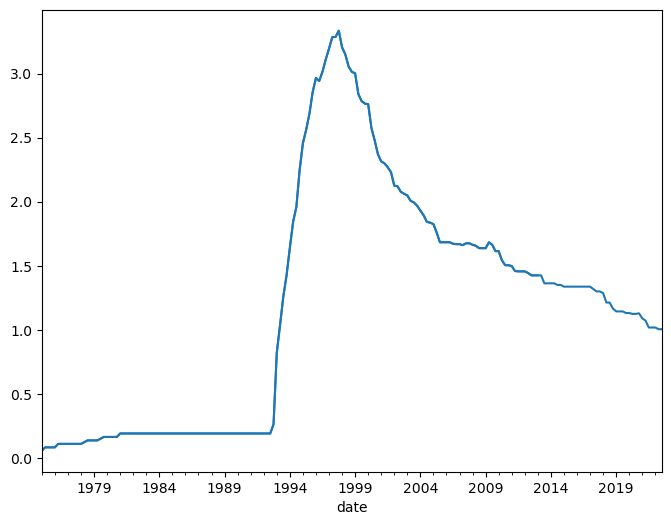

In [109]:
plot_features = df['risk']
plot_features.index = date_time
_ = plot_features.plot(subplots=True)
plot_features = df['risk'][:153]
plot_features.index = date_time[:153]
_ = plot_features.plot(subplots=True)

In [105]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
risk,191.0,2.688595,2.167496,0.131937,0.547734,2.663387,3.79684,7.717429


In [124]:
column_indices = {name: i for i, name in enumerate(df.columns)}

In [110]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.1):]

num_features = df.shape[1]

In [111]:
# 정규화
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

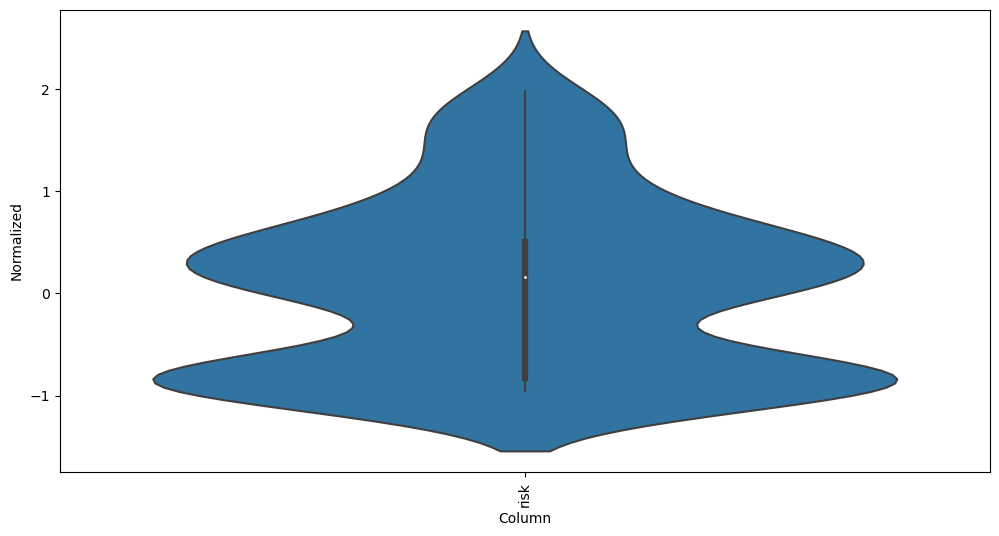

In [112]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [113]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [114]:
w1 = WindowGenerator(input_width=4, label_width=1, shift=1,
                     label_columns=['risk'])
w1

Total window size: 5
Input indices: [0 1 2 3]
Label indices: [4]
Label column name(s): ['risk']

In [115]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [135]:
def plot(self, model=None, plot_col='risk', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [116]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [117]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [118]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 4, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [119]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['risk'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['risk']

In [120]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [121]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [131]:
baseline = Baseline(label_index=column_indices['risk'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

2/2 [==============================] - 0s 2ms/step - loss: 4.0599e-04 - mean_absolute_error: 0.0108


In [132]:
wide_window = WindowGenerator(
    input_width=4, label_width=1, shift=1,
    label_columns=['risk'])

wide_window

Total window size: 5
Input indices: [0 1 2 3]
Label indices: [4]
Label column name(s): ['risk']

In [133]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 4, 1)
Output shape: (32, 4, 1)


ValueError: x and y must be the same size

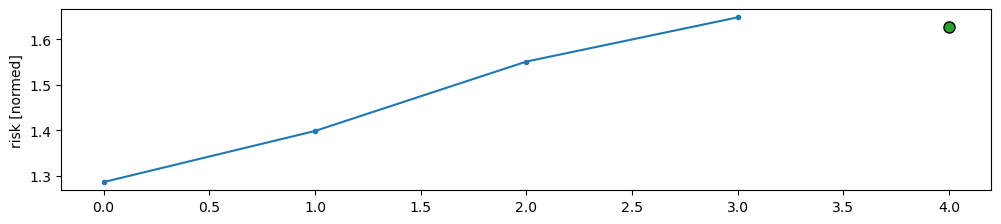

In [136]:
wide_window.plot(baseline)

In [137]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [138]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 1)
Output shape: (32, 1, 1)


In [139]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [140]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
5/5 [==============================] - 0s 31ms/step - loss: 1.1742 - mean_absolute_error: 1.0073 - val_loss: 0.1099 - val_mean_absolute_error: 0.3126
Epoch 2/20
5/5 [==============================] - 0s 14ms/step - loss: 1.1632 - mean_absolute_error: 1.0024 - val_loss: 0.1093 - val_mean_absolute_error: 0.3118
Epoch 3/20
5/5 [==============================] - 0s 12ms/step - loss: 1.1530 - mean_absolute_error: 0.9979 - val_loss: 0.1079 - val_mean_absolute_error: 0.3097
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 1.1420 - mean_absolute_error: 0.9932 - val_loss: 0.1072 - val_mean_absolute_error: 0.3088
Epoch 5/20
5/5 [==============================] - 0s 11ms/step - loss: 1.1320 - mean_absolute_error: 0.9887 - val_loss: 0.1067 - val_mean_absolute_error: 0.3081
Epoch 6/20
5/5 [==============================] - 0s 9ms/step - loss: 1.1217 - mean_absolute_error: 0.9842 - val_loss: 0.1062 - val_mean_absolute_error: 0.3075
Epoch 7/20
5/5 [====================

ValueError: x and y must be the same size

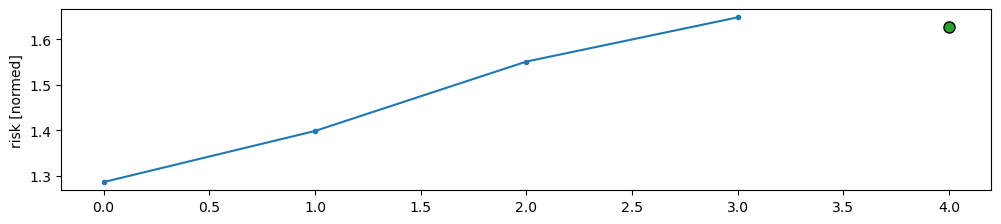

In [141]:
wide_window.plot(linear)